### Comparing Kmeans vs DBSCAN

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12, 12]
np.random.seed(42)

**Import Data**

"This dataset was populated from destination reviews published by 249 reviewers of holidayiq.com till October 2014. Reviews falling in 6 categories among destinations across South India were considered and the count of reviews in each category for every reviewer (traveler) is captured."
Link to the data:https://archive.ics.uci.edu/ml/datasets/BuddyMove+Data+Set#


In [3]:
df=pd.read_csv('data/buddymove_holidayiq.csv') 

In [4]:
df.shape

(249, 7)

In [5]:
df.head()

,User Id,Sports,Religious,Nature,Theatre,Shopping,Picnic
0,User 1,2,77,79,69,68,95
1,User 2,2,62,76,76,69,68
2,User 3,2,50,97,87,50,75
3,User 4,2,68,77,95,76,61
4,User 5,2,98,54,59,95,86


In [6]:
df_new=df.drop('User Id', axis=1) #Excluding UserId

Data Reporting

In [7]:
import pandas_profiling
pandas_profiling.ProfileReport(df_new)

Number of variables,6
Number of observations,249
Total Missing (%),0.0%
Total size in memory,11.8 KiB
Average record size in memory,48.3 B
Numeric,6
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,0


**scaling data**

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaler.fit(df_new)
df_scaled=pd.DataFrame(scaler.transform(df_new))

df_scaled.head()

,0,1,2,3,4,5
0,-1.512592,-1.012048,-0.999351,-1.477403,-1.076163,-0.779962
1,-1.512592,-1.475170,-1.065216,-1.259117,-1.052055,-1.609003
2,-1.512592,-1.845668,-0.604160,-0.916097,-1.510114,-1.394067
3,-1.512592,-1.289922,-1.043261,-0.666628,-0.883296,-1.823940
4,-1.512592,-0.363678,-1.548227,-1.789239,-0.425237,-1.056309


**PCA on scaled data**

In [9]:
df_scaled_pca = PCA(n_components=2).fit_transform(df_scaled)
df_scaled_pca = pd.DataFrame(df_scaled_pca, columns=["PC1", "PC2"])

df_scaled_pca.head()

,PC1,PC2
0,-2.727567,0.492964
1,-3.255847,0.338331
2,-3.285387,-0.481321
3,-3.024548,0.307106
4,-2.540461,1.581887


### VISUALIZATION

**bokeh**

In [10]:
from bokeh.io import output_notebook

from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.models import HoverTool

output_notebook()

Loading BokehJS ...

In [11]:
source = ColumnDataSource(df_scaled_pca)

hover = HoverTool(tooltips=[
    ("(x,y)", "($x, $y)")#,
    #("df_new", "@df_new"),
])

p = figure(plot_width=800, plot_height=800, tools=[hover,"box_zoom", "pan", "zoom_out", "zoom_in"],
           title="2 Principal Components of the scaled data")

p.circle('PC1', 'PC2', size=20, source=source, fill_alpha=0.5)

show(p);

### CLUSTERING

Metrics:

Compute the mean Silhouette Coefficient of all samples.

The Silhouette Coefficient is calculated using the **mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample**. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.

This function returns the mean Silhouette Coefficient over all samples. To obtain the values for each sample, use silhouette_samples.

The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

**Kmeans**

In [12]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_completeness_v_measure,homogeneity_score

To compare the silhouette_score through data,scaled data and scaled_pca data, combining number od clusters

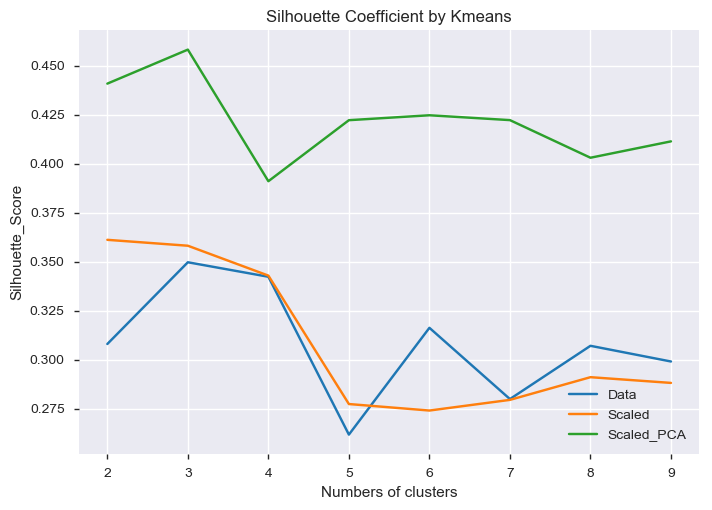

In [13]:
results=[]
results_scaled=[]
results_scaled_pca=[]
range_=range(2,10)
for no_clus in range_:
    clus_kmeans = KMeans(n_clusters=no_clus)
    results.append(silhouette_score(df_new,clus_kmeans.fit(df_new).labels_))

    clus_kmeans_scaled = KMeans(n_clusters=no_clus)
    results_scaled.append(silhouette_score(df_scaled,clus_kmeans_scaled.fit(df_scaled).labels_))

    clus_kmeans_scaled_pca = KMeans(n_clusters=no_clus)
    results_scaled_pca.append(silhouette_score(df_scaled_pca,clus_kmeans_scaled_pca.fit(df_scaled_pca).labels_))

line_chart1 = plt.plot(range_, results)
line_chart1 = plt.plot(range_, results_scaled)
line_chart1 = plt.plot(range_, results_scaled_pca)
plt.title('Silhouette Coefficient by Kmeans')
plt.xlabel('Numbers of clusters')
plt.ylabel('Silhouette_Score')
plt.legend(['Data','Scaled','Scaled_PCA'], loc=4)
plt.show()

As we can see above the best Silhouette_Score is using 3 clusters with scaled_pca data

Training again to plot the clustering:

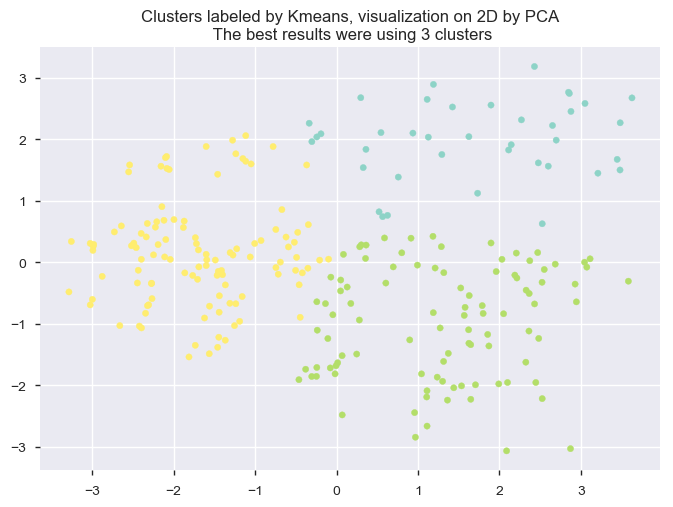

In [14]:
clus_kmeans_scaled_pca_best = KMeans(n_clusters=3)
labels_best=clus_kmeans_scaled_pca_best.fit(df_scaled_pca).labels_

plt.scatter(df_scaled_pca['PC1'],df_scaled_pca['PC2'], c=labels_best,s=20, marker = 'o', cmap=cm.Set3)
plt.title("Clusters labeled by Kmeans, visualization on 2D by PCA\n The best results were using 3 clusters");

**DBSCAN**

To compare the silhouette_score through data,scaled data and scaled_pca data, combining some hyper-parameters(eps,min_samples)

In [15]:
from sklearn.cluster import DBSCAN
eps_list=np.linspace(0.1,3,10)
min_samples_list=range(2,12)
results=[]
results_scaled=[]
results_scaled_pca=[]
for i in range(10):
    clustering = DBSCAN(eps=eps_list[i], min_samples=min_samples_list[i], algorithm ='kd_tree').fit(df_new)
    clustering.labels_
    no_clusters=len(np.unique(clustering.labels_))
    if no_clusters>1:
        results.append([silhouette_score(df_new,clustering.labels_),no_clusters,eps_list[i],min_samples_list[i]])
    
    clustering = DBSCAN(eps=eps_list[i], min_samples=min_samples_list[i], algorithm ='kd_tree').fit(df_scaled)
    clustering.labels_
    no_clusters=len(np.unique(clustering.labels_))
    if no_clusters>1:
        results_scaled.append([silhouette_score(df_scaled,clustering.labels_),no_clusters,eps_list[i],min_samples_list[i]])
    
    clustering = DBSCAN(eps=eps_list[i], min_samples=min_samples_list[i], algorithm ='kd_tree').fit(df_scaled_pca)
    clustering.labels_
    no_clusters=len(np.unique(clustering.labels_))
    if no_clusters>1:
        results_scaled_pca.append([silhouette_score(df_scaled_pca,clustering.labels_),no_clusters,eps_list[i],min_samples_list[i]])

In [16]:
def conv_dataframe(list_results): #to convert the list above on dataframes
    if len(list_results)>0:
        return pd.DataFrame(list_results, columns=['silhouette_score','num_clusters','eps','min_samples'])

results=conv_dataframe(results)
results_scaled=conv_dataframe(results_scaled) 
results_scaled_pca=conv_dataframe(results_scaled_pca) 

In [17]:
print('Score by data original(except User Id)')
print(results,':Had just one cluster')

Score by data original(except User Id)
None :Had just one cluster


In [18]:
print('Score by scaled data')
results_scaled

Score by scaled data


,silhouette_score,num_clusters,eps,min_samples
0,0.003755,3,0.100000,2
1,-0.054899,23,0.422222,3
2,0.118647,22,0.744444,4
3,0.002399,4,1.066667,5
4,0.399042,2,1.388889,6
5,0.399042,2,1.711111,7


In [19]:
print('Score by scaled_pca data')
results_scaled_pca

Score by scaled_pca data


,silhouette_score,num_clusters,eps,min_samples
0,-0.284713,35,0.100000,2
1,-0.034892,11,0.422222,3
2,0.210362,2,0.744444,4


Training again to plot the clustering:

Number of clusters:  5
Silhouette_Score:  0.014540914126293688


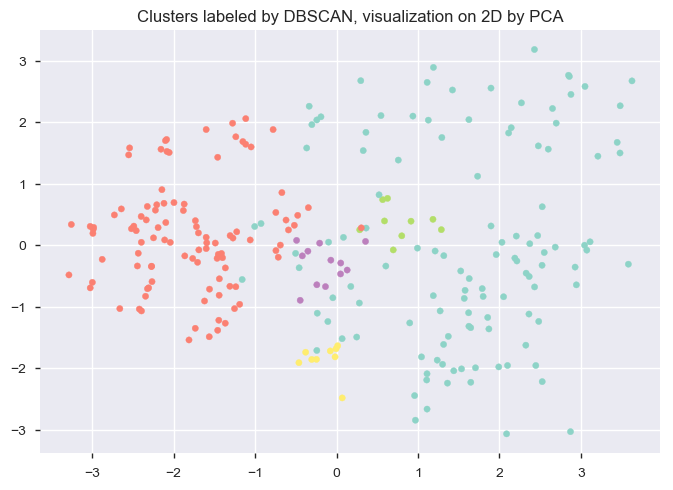

In [20]:
clustering = DBSCAN(eps=1, min_samples=10, algorithm ='kd_tree').fit(df_scaled)
print('Number of clusters: ', len(np.unique(clustering.labels_)))
print('Silhouette_Score: ',silhouette_score(df_scaled,clustering.labels_))
    

plt.scatter(df_scaled_pca['PC1'],df_scaled_pca['PC2'], c=clustering.labels_,s=20, marker = 'o', cmap=cm.Set3)
plt.title("Clusters labeled by DBSCAN, visualization on 2D by PCA");